In [8]:
import pandas as pd
import numpy as np
import psycopg2
import math
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as scs
import scipy
import itertools
sns.set(font_scale=1.5)

In [9]:
#Create connection and cursor
conn = psycopg2.connect("dbname=pfxbaseballdata")
cur = conn.cursor()

In [10]:
# Define query
query = """
SELECT DISTINCT(fgd.play_guid)
, bst.games             
, bst.plate_apps        
, bst.ab                
, bst.h                 
, bst.b1                  
, bst.b2                
, bst.b3                
, bst.hr               
, bst.r             
, bst.rbi                 
, bst.bb               
, bst.ibb       
, bst.so                
, bst.hbp         
, bst.sf            
, bst.sh               
, bst.gdp               
, bst.sb                  
, bst.cs                 
, bst.ba_avg        
, bst.bb_percent        
, bst.k_percent        
, bst.bb_to_k                       
, bst.obp                
, bst.slg                
, bst.ops                 
, bst.iso                 
, bst.babip              
, bst.w_rc                
, bst.w_raa               
, bst.w_oba               
, bst.wrc_plus            
, bst.gb_to_fb 
, bst.ld_percent        
, bst.gb_percent       
, bst.fb_percent        
, bst.iffb_percent    
, bst.hr_to_fb             
, bst.pull_percent     
, bst.center_percent   
, bst.oppo_percent       
, bst.soft_percent      
, bst.med_percent   
, bst.hard_percent
, bst.playerid
, fgd.batter_id
, fgd.ab_id
, fgd.des
, fgd.stand
, fgd.strikes
, fgd.balls
, fgd.p_throws
, fgd.gid
, fgd.pdes
, fgd.inning
, pst.wins
, pst.losses
, pst.saves
, pst.games
, pst.games_started
, pst.innings_pitched
, pst.k_per_9
, pst.bb_per_9 
, pst.hr_per_9
, pst.babip
, pst.lob_percent
, pst.gb_percent
, pst.hr_to_fb
, pst.era
, pst.fip
, pst.xfip
, pst.war
, pst.playerid  
FROM fg_game_data AS fgd
INNER JOIN pitcher_stats_table AS pst ON fgd.pitcher_fg_id = pst.playerid
INNER JOIN batter_stats_table AS bst ON fgd.batter_fg_id = bst.playerid
;
"""
#Execute the query
cur.execute(query)
# Return the next row
GameData = cur.fetchall()

In [11]:
GameData_df = pd.DataFrame(GameData, columns=["play_guid", "batter_games", "batter_plate_apps", "batter_ab", "batter_h"
                                              ,"batter_1b", "batter_2b", "batter_3b", "batter_hr", "batter_r", "batter_rbi"                 
                                              ,"batter_bb", "batter_ibb", "batter_so", "batter_hbp", "bater_sf", "batter_sh"
                                              ,"batter_gdp", "batter_sb", "batter_cs", "batter_avg", "batter_bb_percent"
                                              ,"batrer_k_percent", "batter_bb_to_k", "batter_obp", "batter_slg", "batter_ops"
                                              ,"batter_iso", "batter_babip", "batter_w_rc", "batter_w_raa", "batter_w_oba"
                                              ,"batter_wrc_plus", "batter_gb_to_fb", "batter_ld_percent", "batter_gb_percent"
                                              ,"batter_fb_percent", "batter_iffb_percent", "batter_hr_to_fb", "batter_pull_percent"
                                              ,"batter_center_percent", "batter_oppo_percent", "batter_soft_percent"
                                              ,"batter_med_percent", "batter_hard_percent", "batter_playerid", "mlb_batter_id"
                                              ,"ab_id", "des", "stand", "strikes", "balls", "p_throws", "gid", "pdes"
                                              ,"inning", "pitcher_wins", "pitcher_losses", "pitcher_saves", "pitcher_games"
                                              ,"pitcher_games_started", "pitcher_innings_pitched", "pitcher_k_per_9"
                                              ,"pitcher_bb_per_9", "pitcher_hr_per_9", "pitcher_babip", "pitcher_lob_percent"
                                              ,"pitcher_gb_percent", "pitcher_hr_to_fb", "pitcher_era", "pitcher_fip"
                                              ,"pitcher_xfip", "pitcher_war", "pitcher_playerid"])

cleanGameData_df = GameData_df

In [12]:
#convert right vs left hander batter to binary
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
cleanGameData_df['batter_stance'] = batter_stance

In [13]:
#convert right vs left hander pitcher to binary
right_left_handness = []
for pitcher in GameData_df.loc[:,]['p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
cleanGameData_df['pitcher_handedness'] = right_left_handness

In [49]:
#Convert probabilities within data set to log odds for logistic regression analysis
#Log Odds: LO = LOGe[Odds]= LOGe[p/(1-p)] 
def proba_to_logodds(probability):
    odds = (probability / (1 - probability))
    logodds = math.log(odds)
    return logodds
#test    
proba_to_logodds(.2)

-1.3862943611198906

In [50]:
#Columns to convert to logodds
columns_to_convert = ["batter_bb_percent", "batter_k_percent", "batter_avg", "batter_obp", "batter_slg"  
                      ,"pitcher_lob_percent","pitcher_gb_percent", "pitcher_hr_fb_percent", "batter_ld_percent"
                      , "batter_gb_percent","batter_fb_percent", "batter_iffb_percent"]
labels = ["BB_logodds", "K_logodds", "BA_AVG_logodds", "b_OBP_logodds", "b_SLG_logodds", "p_lob_logodds"
          ,"p_gb_logodds", "p_hr_fb_logodds", "batter_ld_logodds", "batter_gb_logodds", "batter_fb_logodds"
          , "batter_iffb_logodds"]

In [51]:
def convert_to_logodds(list_DFs, labels):
    for idx, DF in enumerate(list_DFs):
        temp_lst = []
        for i in cleanGameData_df.iloc[:,][DF]:
            temp_lst.append(proba_to_logodds(i))
        cleanGameData_df[labels[idx]] = temp_lst
        
convert_to_logodds(columns_to_convert, labels)

ValueError: math domain error

In [ ]:
def log5_method(x, y, z=.255):
    log5_metric = []
    log5_answer = ((x * y) / z) / ((x * y) / z) + ((1 - x) * (1 - y) / (1 - z))
    log5_metric.append(log5_answer)

In [ ]:
for index, row in GameData_df.iterrows():
    log5_method(GameData_df['b_ba_avg'], GameData_df[''])

In [7]:
#AB_outcome predictions dropped columns
cleanGameData_df = cleanGameData_df.drop(columns=["play_guid", "p_throws", "stand","batter_playerid","pitcher_playerid"
                                                  ,"mlb_batter_id", 'strikes', 'balls', 'pdes','gid'
                                                  ,"batter_1b", "batter_2b", "batter_3b", "batter_hr", "batter_r", "batter_rbi"                 
                                                  ,"batter_bb", "batter_ibb","batter_iso", "batter_babip", "batter_w_rc", "batter_w_raa", "batter_w_oba"
                                                  ,"batter_wrc_plus", "batter_gb_to_fb", "batter_ld_percent", "batter_gb_percent"
                                                  ,"batter_fb_percent", "batter_iffb_percent", "batter_hr_to_fb", "batter_pull_percent"
                                                  ,"batter_center_percent", "batter_soft_percent","batter_med_percent", "batter_hard_percent"
                                                  ,"pitcher_hr_per_9", "pitcher_babip", "pitcher_lob_percent","pitcher_gb_percent", "pitcher_hr_to_fb"
                                                  ,"batter_hbp", "bater_sf", "batter_sh","batter_sb","batter_cs", "batter_bb_to_k","batter_obp"
                                                  ,"batter_ops", "pitcher_wins","pitcher_innings_pitched","pitcher_fip"
                                                  , "batter_gdp", "batter_slg", "pitcher_games_started", "batter_bb_percent"
                                                  , "batter_ab", "pitcher_saves", "batter_games"])


In [14]:
cleanGameData_df = cleanGameData_df.drop(columns=[


In [55]:
cleanGameData_df.iloc[:,19]

0        0.237960
1        0.241667
2        0.187739
3        0.357143
4        0.231144
5        0.217799
6        0.241573
7        0.277592
8        0.241438
9        0.264286
10       0.264286
11       0.286420
12       0.000000
13       0.273302
14       0.325540
15       0.245614
16       0.294118
17       0.235795
18       0.323651
19       0.261134
21       0.000000
22       0.208791
23       0.243243
24       0.260870
25       0.232323
26       0.174242
27       0.249158
28       0.264591
29       0.255853
30       0.285974
           ...   
33327    0.266667
33336    0.254065
33405    0.302326
33407    0.254818
33423    0.194595
33513    0.276888
33515    0.242424
33565    0.228972
33606    0.220848
33672    0.220848
33888    0.214286
33895    0.224832
33916    0.263804
33997    0.260870
34033    0.315966
34050    0.263804
34110    0.243243
34113    0.271074
34179    0.211538
34216    0.234848
34308    0.271074
34339    0.301969
34351    0.246847
34361    0.259516
34372    0

In [15]:
#Remove Duplicate Rows/pitches
cleanGameData_df = cleanGameData_df.drop_duplicates()
cleanGameData_df

,batter_games,batter_plate_apps,batter_ab,batter_h,batter_1b,batter_2b,batter_3b,batter_hr,batter_r,batter_rbi,...,pitcher_babip,pitcher_lob_percent,pitcher_gb_percent,pitcher_hr_to_fb,pitcher_era,pitcher_fip,pitcher_xfip,pitcher_war,batter_stance,pitcher_handedness
0,105,398,353,84,51,18,1,14,45,43,...,0.267,0.773,0.334,0.103,3.84,4.73,4.90,3.5,0,0
1,142,530,480,116,64,34,2,16,63,71,...,0.303,0.699,0.582,0.120,3.91,3.38,3.32,7.1,0,1
2,98,300,261,49,29,12,2,6,35,30,...,0.297,0.703,0.495,0.122,4.38,4.44,4.38,3.8,0,1
3,5,15,14,5,1,1,0,3,3,5,...,0.296,0.724,0.399,0.104,4.20,4.08,4.14,11.1,1,0
4,117,453,411,95,59,22,1,13,45,53,...,0.294,0.746,0.515,0.133,4.08,4.43,4.31,2.3,1,1
5,115,467,427,93,59,18,1,15,60,46,...,0.299,0.724,0.579,0.136,3.91,3.80,3.50,0.9,1,1
6,48,210,178,43,29,7,0,7,27,17,...,0.311,0.700,0.495,0.112,4.13,3.76,3.74,17.4,0,1
7,98,337,299,83,60,14,8,1,46,25,...,0.296,0.700,0.492,0.105,3.82,3.76,3.82,7.9,0,1
8,157,624,584,141,92,26,3,20,61,67,...,0.285,0.753,0.464,0.088,3.27,3.24,3.48,4.1,0,1
9,90,321,280,74,46,12,1,15,35,51,...,0.275,0.766,0.374,0.101,3.39,3.85,3.97,10.0,0,1


In [16]:
#Binary Outcome for logistic regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
for pitch in cleanGameData_df.loc[:,('des')]:
    if pitch in ball_in_play:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
cleanGameData_df['ab_outcome'] = ab_outcome
cleanGameData_df = cleanGameData_df.drop(columns=["des"])

In [17]:
cleanGameData_df = cleanGameData_df.drop_duplicates()

In [18]:
null_equals = cleanGameData_df.isnull()

In [19]:
null_rows = cleanGameData_df.isnull().values.any(axis=1)
non_null_df = cleanGameData_df[~null_rows]

In [20]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=1e9)
X = np.array(non_null_df.drop(['ab_outcome'], axis=1))
y = np.array(non_null_df['ab_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)
logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
logodds_pred = logreg.predict_log_proba(X_test)
proba_pred = logreg.predict_proba(X_test)
basic_log_score = logreg.score(X_test, y_test)

In [21]:
probabilities = []
for i in proba_pred:
    probabilities.append(i[1])

In [22]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=proba_pred[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=proba_pred[:,1])
print(roc_auc)

0.5384947733947494


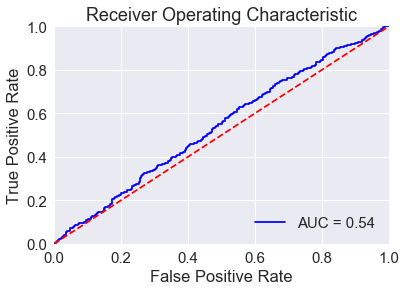

/anaconda/envs/py36/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/envs/py36/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


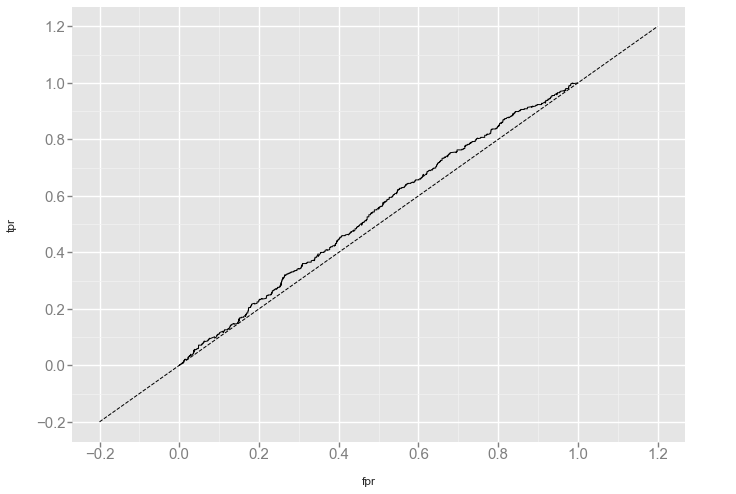

<ggplot: (-9223372036562343438)>

In [23]:
#ROC PLOT
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

Text(0,0.5,'Predicted Pitch Outcome')

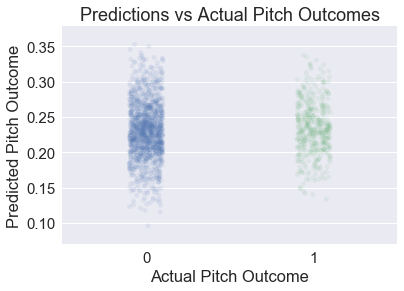

In [120]:
ax = sns.stripplot(x=y_test, y=proba_pred[:,1], jitter=True, alpha=.09)
plt.title('Predictions vs Actual Pitch Outcomes')
# Set x-axis label
plt.xlabel('Actual Pitch Outcome')
# Set y-axis label
plt.ylabel('Predicted Pitch Outcome')

In [24]:
logreg.coef_

array([[-5.63365904e-03, -3.07136483e-02,  1.49385801e-01,
        -5.35893312e-01,  1.23403985e-01, -4.44294864e-02,
        -1.98505806e-01, -4.16362005e-01, -6.78077396e-04,
        -1.02741445e-03, -1.80826705e-01,  1.72846713e-01,
        -5.37683356e-04, -2.08005262e-01,  1.53965334e-01,
        -1.37563562e-02,  6.63788253e-03, -5.22757573e-03,
         1.75321359e-02, -4.40801261e-03,  1.13427396e-01,
         2.66902566e-01, -1.31534747e-01,  4.16096827e-02,
        -2.19244326e-01, -1.77634643e-01, -2.14836313e-01,
         5.64082585e-01,  2.81653964e-01,  2.85272085e-01,
        -7.67605390e-02,  8.64121234e-04, -1.60946190e-01,
         2.33525849e-01,  4.42211022e-01, -5.54140128e-01,
        -4.06122973e-01,  3.64724929e-02, -1.09153158e-01,
        -1.37391219e-01,  5.81646147e-02,  1.16534957e-01,
        -3.32332030e-01,  2.79840674e-02,  6.96197318e-03,
        -4.41415486e-02,  8.70944730e-03,  6.98830885e-03,
         1.48826768e-03,  9.12498087e-04,  6.03779129e-0

### Random Forest

In [25]:
#Random Forest Model
'''sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
RFC = RandomForestClassifier(random_state=16, n_estimators=7500, n_jobs=2)
RFC.fit(X_train, y_train)
rf_predict_proba = RFC.predict_proba(X_test)
rf_predictions = RFC.predict(X_test)
tree_split = RFC.decision_path(X_test)
feature_importance = RFC.feature_importances_

In [26]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=rf_predict_proba[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=rf_predict_proba[:,1])
print(roc_auc)

0.4892441730716014


In [27]:
multinomial_report = metrics.classification_report(y_true=y_test, y_pred=rf_predictions, labels=None, 
                                                   target_names=['Out', 'Hit'], sample_weight=None, digits=2)
multinomial_report

'             precision    recall  f1-score   support\n\n        Out       0.77      0.80      0.79      1383\n        Hit       0.20      0.17      0.19       405\n\navg / total       0.64      0.66      0.65      1788\n'

In [ ]:
count = 0
for prediction in rf_predictions:
    if prediction == 1:
        count += 1
    else:
        continue
count

In [ ]:
updated_threshold = []
for proba in rf_predict_proba[:,1]:
    if proba > 0.25:
        updated_threshold.append(1)
    else:
        updated_threshold.append(0)
sum(updated_threshold)

In [ ]:
ax = sns.stripplot(x=y_test, y=rf_predict_proba[:,1], jitter=True)
plt.title('Predictions vs Actual Pitch Outcomes')
# Set x-axis label
plt.xlabel('Actual Pitch Outcome')
# Set y-axis label
plt.ylabel('Predicted Probability Pitch Outcome')

### Gradient Boosted

In [28]:
"""sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                            criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, init=None, random_state=None, max_features=None
                                            ,verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’)"""
GBC = GradientBoostingClassifier(random_state=16, n_estimators=7500, learning_rate=0.0001)
GBC.fit(X_train, y_train)
gb_predict_proba = GBC.predict_proba(X_test)
gb_predictions = GBC.predict(X_test)
gb_feature_importance = GBC.feature_importances_

In [29]:
gb_feature_importance

array([3.59078280e-07, 3.54970060e-07, 3.26499296e-03, 5.01997471e-03,
       3.04816817e-02, 1.83885507e-02, 0.00000000e+00, 0.00000000e+00,
       1.31265015e-02, 5.01533713e-02, 2.61550549e-07, 1.06945487e-02,
       5.19174315e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.35735629e-07, 8.91544694e-03, 2.51044223e-07, 1.17855698e-01,
       7.67670921e-03, 2.52847867e-02, 2.15320918e-02, 2.44072531e-02,
       1.12668130e-07, 1.73867498e-07, 2.10992097e-03, 3.38300748e-02,
       1.60583665e-02, 1.15188061e-07, 1.86917157e-07, 2.03372709e-07,
       3.03087622e-04, 0.00000000e+00, 4.80035626e-03, 1.19994188e-02,
       1.88215329e-02, 1.55753729e-02, 1.21796005e-02, 2.61431759e-02,
       1.35240985e-01, 3.78471062e-04, 1.22271087e-02, 1.48428859e-02,
       2.78599898e-02, 7.94847192e-03, 3.11431082e-02, 1.31791050e-02,
       0.00000000e+00, 0.00000000e+00, 3.61077990e-04, 7.34280169e-03,
       7.29715098e-02, 0.00000000e+00, 5.14790039e-02, 7.19243673e-03,
      

In [30]:
fpr, tpr, threshold = metrics.roc_curve(y_true=y_test, y_score=gb_predict_proba[:,1])
roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=gb_predict_proba[:,1])
print(roc_auc)

0.5397346973389394


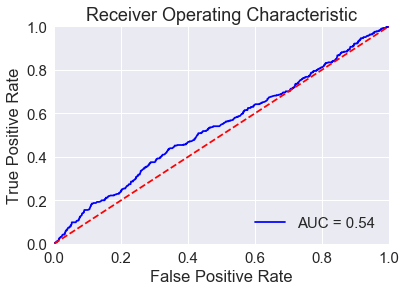

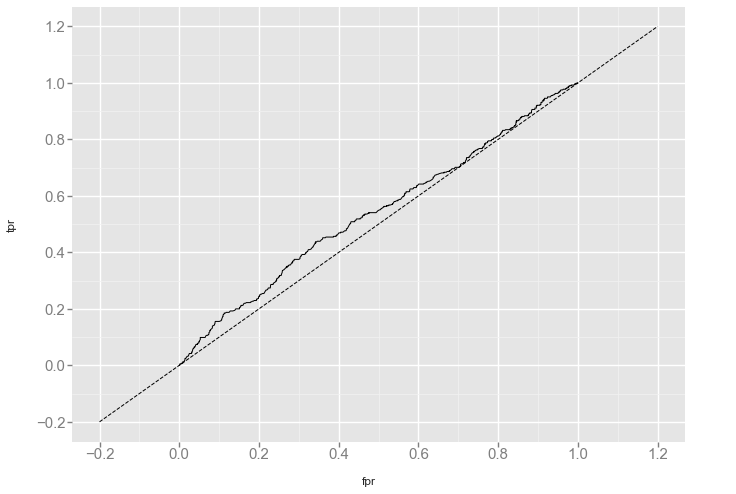

<ggplot: (289893433)>

In [31]:

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [42]:
from __future__ import print_function
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence


def main():

    names = list(non_null_df.drop(['ab_outcome'], axis=1).columns.values)

    features = [44,(44, 45)]
    fig, axs = plot_partial_dependence(GBC, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=100, figsize=(12,4))
    fig.suptitle('Partial dependence Inning and AB_ID vs hit')
    plt.subplots_adjust(top=.8)  # tight_layout causes overlap with suptitle
    
    fig = plt.figure(figsize=(10,6))
    target_feature = (19, 11)
    pdp, axes = partial_dependence(GBC, target_feature,
                                   X=X_train, grid_resolution=100)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence Inning and AB_ID vs hit')
    plt.subplots_adjust(top=0.8)

    plt.show()

sklearn.ensemble.GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                            criterion=’friedman_mse’, min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, init=None, random_state=None, max_features=None
                                            ,verbose=0, max_leaf_nodes=None, warm_start=False, presort=’auto’)


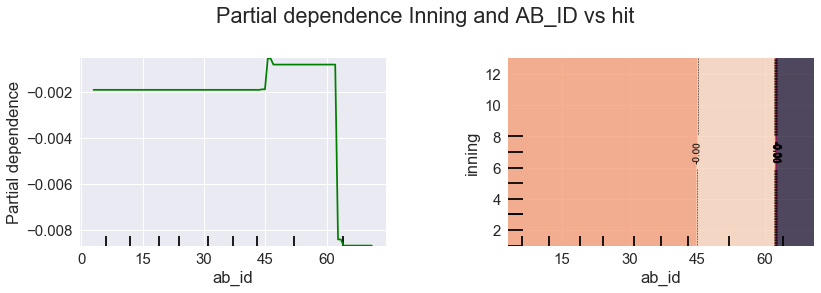

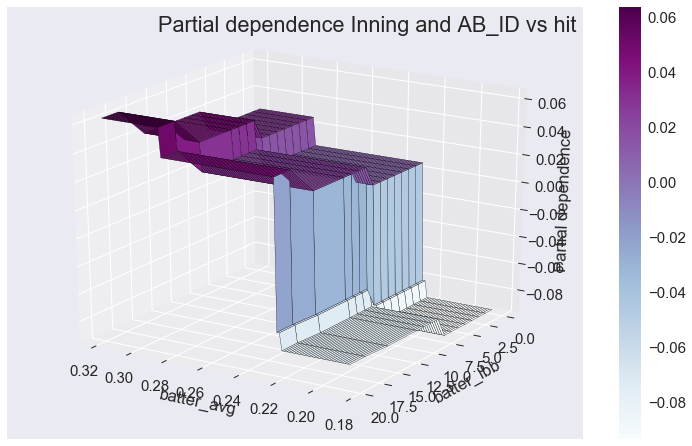

In [43]:
main()

## Multinomial Regression
### Out vs. Walk vs. Hit

In [ ]:
multinomial_GameData_df = cleanGameData_df

In [ ]:
#convert right vs left hander batter to binary
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
multinomial_GameData_df['batter_stance'] = batter_stance

#convert right vs left hander pitcher to binary
right_left_handness = []
for pitcher in GameData_df.loc[:,]['p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
multinomial_GameData_df['pitcher_handedness'] = right_left_handness

In [ ]:
#Convert probabilities within data set to log odds for logistic regression analysis
#Log Odds: LO = LOGe[Odds]= LOGe[p/(1-p)] 
def proba_to_logodds(probability):
    odds = (probability / (1 - probability))
    logodds = math.log(odds)
    return logodds
#test    
proba_to_logodds(.2)

In [ ]:
#Columns to convert to logodds
columns_to_convert = ["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent"]
labels = ["BB_logodds", "K_logodds", "BA_AVG_logodds", "b_OBP_logodds", "b_SLG_logodds", 
          "p_lob_logodds","p_gb_logodds", "p_hr_fb_logodds"]

In [ ]:
def convert_to_logodds(list_DFs, labels):
    for idx, DF in enumerate(list_DFs):
        temp_lst = []
        for i in GameData_df.iloc[:,][DF]:
            temp_lst.append(proba_to_logodds(i))
        multinomial_GameData_df[labels[idx]] = temp_lst
        
convert_to_logodds(columns_to_convert, labels)

In [ ]:
#AB_outcome predictions
multinomial_GameData_df = multinomial_GameData_df.drop(columns=["b_bb_percent", "b_k_percent", "b_ba_avg", "b_obp", "b_slg", "p_lob_percent",
                      "p_gb_percent", "p_hr_fb_percent", "play_guid", "outcome", "p_throws", "stand","b_playerid","b_mlb_id",'p_playerid', 'strikes', 'balls', 'pitch_outcome'])



In [ ]:
#Multiclass Outcome for multinomial regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
walk = ['Walk']
for pitch in cleanGameData_df.loc[:,]['outcome']:
    if pitch in ball_in_play:
        ab_outcome.append(2)
    elif pitch in walk:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
multinomial_GameData_df['ab_outcome'] = ab_outcome
multinomial_GameData_df = multinomial_GameData_df.drop(columns=['outcome'])

In [ ]:
multinomial_GameData_df

In [ ]:
# fit a multinomial regression model and store the class predictions
multi_logreg = LogisticRegression(C=1e12, multi_class='multinomial', solver='lbfgs', max_iter=2000)
X = np.array(multinomial_GameData_df.iloc[:,0:40])
y = np.array(multinomial_GameData_df['ab_outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
multi_logreg.fit(X_train, y_train)
#hit_proba = logreg.predict_proba(X)
multi_logodds_pred = multi_logreg.predict_log_proba(X_test)
multi_proba_pred = multi_logreg.predict_proba(X_test)
multi_basic_log_score = multi_logreg.score(X_test, y_test)
multi_prediction = multi_logreg.predict(X_test)

In [ ]:
multinomial_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=multi_prediction, normalize=True, 
                                              sample_weight=None)
multinomial_accuracy

In [ ]:
multi_probabilities = []
for i in multi_probabilities:
    multi_probabilities.append(i[1])

In [ ]:
multi_proba_pred

In [ ]:
#Multi Class Random Forest Model
'''sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                              max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                              min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, 
                                              random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
RFC = RandomForestClassifier(random_state=16, n_estimators=1000)
RFC.fit(X_train, y_train)
multi_rf_predict = RFC.predict(X_test)
multi_tree_split = RFC.decision_path(X_test)
multi_feature_importance = RFC.feature_importances_

In [ ]:
multinomial_rf_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=multi_rf_predict, normalize=True, 
                                              sample_weight=None)
multinomial_rf_accuracy

In [ ]:
ax = sns.stripplot(x=y_test, y=multi_rf_predict, jitter=True,)
plt.title('Predictions for AB Outcomes')
# Set x-axis label
plt.xlabel('AB Outcome')
# Set y-axis label
plt.ylabel('AB Prediction')


In [ ]:
multinomial_report = metrics.classification_report(y_true=y_test, y_pred=multi_rf_predict, labels=None, 
                                                   target_names=['Out', 'Walk', 'Hit'], sample_weight=None, digits=2)
multinomial_report

In [ ]:
roc_curve = metrics.roc_curve(y_true=y_test, y_score=rf_predict_proba[:,1])

roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=rf_predict_proba[:,1])
print(roc_auc)